In [1]:
import matplotlib.pyplot as plt 
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from strain_utils import anim_sequence,drift_comp
import pickle
from scipy.io import loadmat
from skimage.transform import resize
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

In [2]:
# read image sequence, mask sequence 
# read tracking information 
mat = loadmat('/user/yyang/home/100MyEchoECG/models/EchoMotionTracking/PAM/test_kpt+jacobian+track.mat')
img_sq = mat['img']
myo_ed = mat['mask_ed']
frame_ed = mat['ed']
pos_sq = (mat['tracking'] + 1) * 63.5
kpts = (mat['kpt'] + 1) * 63.5
jacobian = mat['jacobian']
grid = np.stack(np.meshgrid(np.arange(128), np.arange(128)), axis=0)
pos_sq = np.concatenate([np.expand_dims(grid, 0), np.transpose(pos_sq, (0,3,1,2))], axis=0)

### Key point trace 

(128.0, 0.0)

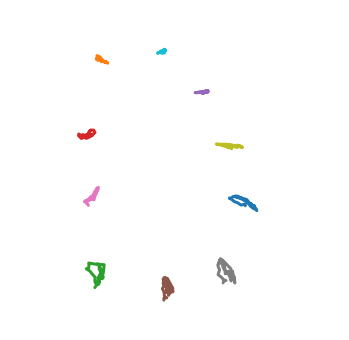

In [3]:
import seaborn as sns
sns.set_style('white')
plt.figure(figsize=(6,6))
#plt.imshow(img_sq[frame_ed], cmap='gray')#, alpha=0.5)
plt.axis('off')
for i in range(10):
    plt.plot(kpts[:,i,0], kpts[:,i,1], linewidth=3)
plt.xlim(0,128)
plt.ylim(128,0)

### Myocardium tracking 

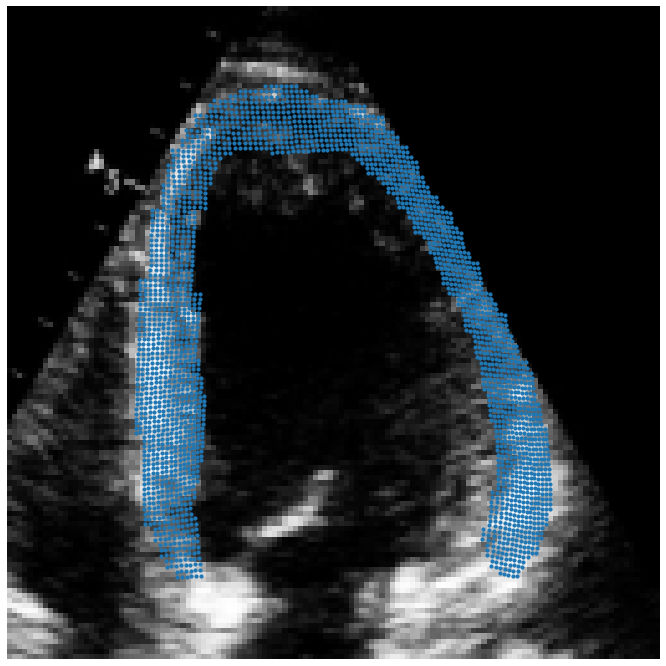

In [4]:
from skimage.measure import find_contours
ed_traj = pos_sq[:, ::-1]
myoidx = np.where(myo_ed)
f = 20
plt.figure(figsize=(12,12))
plt.imshow(img_sq[f], cmap='gray')
plt.axis('off')
s = 1
plt.scatter(ed_traj[f, 1, myoidx[0], myoidx[1]], ed_traj[f,0, myoidx[0], myoidx[1]], s=10)

### Strain calculation 

In [9]:
from strain_utils import *
strain_ob = AHA_strain(n_cluster=8, img_size=128, myo=myo_ed, lv=None, resol=[1,1])

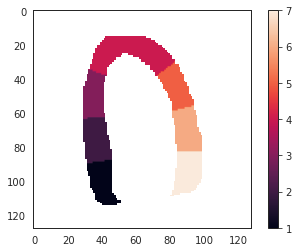

In [10]:
# AHA 7 components 
mask_knn = np.zeros((128,128))
for i in range(4):
    idx = np.where(strain_ob.mask_knns[i]==1)
    mask_knn[idx] = i+1
for i in range(4,8):
    idx = np.where(strain_ob.mask_knns[i]==1)
    mask_knn[idx]=i
idx = np.where(mask_knn==0)
mask_knn[idx] = np.nan
plt.imshow(mask_knn)
plt.colorbar()

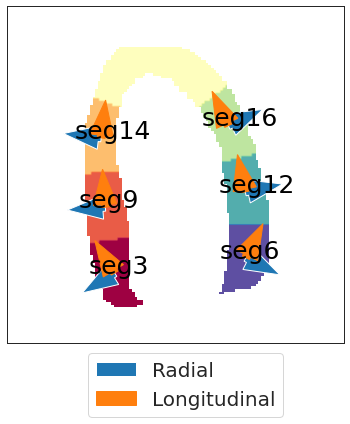

In [11]:
# Strain direction 
ch = 4
if ch == 4:
    seg_names = ['seg3', 'seg9', 'seg14', 'seg16', 'seg12', 'seg6']
else:
    seg_names = ['seg4', 'seg10', 'seg15', 'seg13', 'seg7', 'seg1']
seg_nums = [0, 1, 2, 5, 6, 7]
plt.figure(figsize=(6,6))
plt.imshow(mask_knn, cmap='Spectral')
# plt.scatter(strain_ob.centers[:,1], strain_ob.centers[:,0])
o = 0
for i in seg_nums[:-1]:
    plt.text(strain_ob.centers[i, 1] - 10, strain_ob.centers[i, 0], seg_names[o], color='k', size=25)
    o += 1
    plt.arrow(strain_ob.centers[i, 1], strain_ob.centers[i, 0], strain_ob.aha_radial_dir[i, 0],
              strain_ob.aha_radial_dir[i, 1], width=3)
    plt.arrow(strain_ob.centers[i, 1], strain_ob.centers[i, 0], strain_ob.aha_longitudinal_dir[i, 0],
              strain_ob.aha_longitudinal_dir[i, 1], width=3, color='tab:orange')
i = seg_nums[-1]
plt.text(strain_ob.centers[i, 1] - 10, strain_ob.centers[i, 0], seg_names[o], color='k', size=25)
plt.arrow(strain_ob.centers[i, 1], strain_ob.centers[i, 0], strain_ob.aha_radial_dir[i, 0],
          strain_ob.aha_radial_dir[i, 1], width=3, label='Radial')
plt.arrow(strain_ob.centers[i, 1], strain_ob.centers[i, 0], strain_ob.aha_longitudinal_dir[i, 0],
          strain_ob.aha_longitudinal_dir[i, 1], width=3, color='tab:orange', label='Longitudinal')
    # plt.arrow(strain_ob.centers[i, 1], strain_ob.centers[i, 0], 5, -5, width=3)
plt.legend(bbox_to_anchor=(0.85, 0), fontsize=20)
#plt.colorbar()
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.tight_layout()

In [12]:
oriE_all = []
rad_aha_all = []
long_aha_all = []
dis_aha_all = []
dis_aha_norm_all = []
for i in range(len(pos_sq)):
    oriE, rad_aha, long_aha = strain_ob.calculate_aha_strain(pos_sq[i])
    dis_aha, _, dis_aha_norm = strain_ob.calculate_aha_displacement(pos_sq[i])
    oriE_all.append(oriE)
    rad_aha_all.append(rad_aha)
    long_aha_all.append(long_aha)
    dis_aha_all.append(dis_aha)
    dis_aha_norm_all.append(dis_aha_norm)
oriE_all = np.array(oriE_all)
rad_aha_all = np.array(rad_aha_all)
long_aha_all = np.array(long_aha_all)
dis_aha_all = np.array(dis_aha_all)
dis_aha_norm_all = np.array(dis_aha_norm_all)

Text(0.5, 1.0, 'Longitudinal strain')

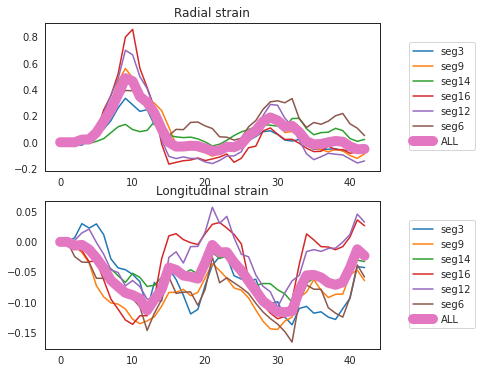

In [14]:
plt.figure(figsize=(6,6))
plt.subplot(211)
k = 0
for i in seg_nums:
    plt.plot(rad_aha_all[:, i], label=seg_names[k])
    k += 1
plt.plot(np.mean(rad_aha_all[:, seg_nums], axis=1), label='ALL', linewidth=10)
plt.legend(bbox_to_anchor=(1.3, 0.9))
plt.title('Radial strain')
plt.subplot(212)
k = 0
for i in seg_nums:
    plt.plot(long_aha_all[:, i], label=seg_names[k])
    k += 1
plt.plot(np.mean(long_aha_all[:, seg_nums], axis=1), label='ALL', linewidth=10)
plt.legend(bbox_to_anchor=(1.3, 0.9))
plt.title('Longitudinal strain')